#sweq2seq

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from wordcloud import WordCloud
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()
import warnings

import re
import nltk
# import contractions
# import rouge
import difflib
from tensorflow.keras import callbacks, models, layers, preprocessing as kprocessing
import transformers

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
!pip install gensim
import gensim

  Obtaining dependency information for gensim from https://files.pythonhosted.org/packages/e8/d9/104988573fd2c1acdc64e66883b35fb8ae559310d2d9f77db78bf7de9add/gensim-4.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for smart-open>=1.8.1 from https://files.pythonhosted.org/packages/fc/d9/d97f1db64b09278aba64e8c81b5d322d436132df5741c518f3823824fae0/smart_open-6.4.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 8.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 28.0 MB/s eta 0:00:00


In [ ]:
!pip install datasets
from datasets import load_dataset
data = load_dataset("cnn_dailymail", '1.0.0')
data_train = pd.DataFrame(data['train'])
data_test = pd.DataFrame(data['test'])
data_val = pd.DataFrame(data['validation'])

In [ ]:
Data = pd.concat([data_train, data_test, data_val], ignore_index=True)

In [ ]:
Data.head()
print(Data.shape)

(311971, 3)


In [ ]:
Data.head()

,article,highlights,id
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a


In [ ]:
Data.drop(['id'], axis = 1, inplace = True)
Data.head()

,article,highlights
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa..."
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non..."
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical..."


In [ ]:
#Removes non-alphabetic characters:
def text_strip(column):
    for row in column:

        #ORDER OF REGEX IS VERY VERY IMPORTANT!!!!!!

        row=re.sub("(\\t)", ' ', str(row)).lower() #remove escape charecters
        row=re.sub("(\\r)", ' ', str(row)).lower()
        row=re.sub("(\\n)", ' ', str(row)).lower()

        row=re.sub("(__+)", ' ', str(row)).lower()   #remove _ if it occors more than one time consecutively
        row=re.sub("(--+)", ' ', str(row)).lower()   #remove - if it occors more than one time consecutively
        row=re.sub("(~~+)", ' ', str(row)).lower()   #remove ~ if it occors more than one time consecutively
        row=re.sub("(\+\++)", ' ', str(row)).lower()   #remove + if it occors more than one time consecutively
        row=re.sub("(\.\.+)", ' ', str(row)).lower()   #remove . if it occors more than one time consecutively

        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() #remove <>()|&©ø"',;?~*!

        row=re.sub("(mailto:)", ' ', str(row)).lower() #remove mailto:
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() #remove \x9* in text
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() #replace INC nums to INC_NUM
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() #replace CM# and CHG# to CM_NUM


        row=re.sub("(\.\s+)", ' ', str(row)).lower() #remove full stop at end of words(not between)
        row=re.sub("(\-\s+)", ' ', str(row)).lower() #remove - at end of words(not between)
        row=re.sub("(\:\s+)", ' ', str(row)).lower() #remove : at end of words(not between)

        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces

        #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass #there might be emails with no url in them



        row = re.sub("(\s+)",' ',str(row)).lower() #remove multiple spaces

        #Should always be last
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces

        yield row

In [ ]:
# !pip install spacy
# !python -m spacy download en_core_web_sm

In [ ]:
from time import time
import spacy
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

# Count the items in the generator
brief_cleaning1 = text_strip(Data['article'])
brief_cleaning1_count = sum(1 for _ in brief_cleaning1)

# Recreate the generator
brief_cleaning1 = text_strip(Data['article'])

t = time()

# Process the data with tqdm and nlp.pipe()
text = [str(doc) for doc in tqdm(nlp.pipe(brief_cleaning1, batch_size=3000), total=brief_cleaning1_count)]

# Print the time taken for the operation
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

100%|██████████| 311971/311971 [4:23:36<00:00, 19.72it/s]

Time to clean up everything: 263.61 mins


In [ ]:
brief_cleaning2 = text_strip(Data['highlights'])
brief_cleaning2_count = sum(1 for _ in brief_cleaning2)

# Recreate the generator
brief_cleaning2 = text_strip(Data['highlights'])

# Batch the data points into 3000 and run on all cores for faster preprocessing
summary = ['_START_ ' + str(doc) + ' _END_' for doc in tqdm(nlp.pipe(brief_cleaning2, batch_size=3000), total=brief_cleaning2_count)]

# Print the time taken for the operation
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

100%|██████████| 311971/311971 [20:27<00:00, 254.10it/s]

Time to clean up everything: 284.56 mins


In [ ]:
text[0]

'london england reuters harry potter star daniel radcliffe gains access to reported £20 million $41.1 million fortune as he turns 18 on monday but he insists the money won cast spell on him daniel radcliffe as harry potter in harry potter and the order of the phoenix to the disappointment of gossip columnists around the world the young actor says he has no plans to fritter his cash away on fast cars drink and celebrity parties don plan to be one of those people who as soon as they turn 18 suddenly buy themselves massive sports car collection or something similar he told an australian interviewer earlier this month don think ll be particularly extravagant the things like buying are things that cost about 10 pounds books and cds and dvds at 18 radcliffe will be able to gamble in casino buy drink in pub or see the horror film hostel part ii currently six places below his number one movie on the uk box office chart details of how he ll mark his landmark birthday are under wraps his agent a

In [ ]:
summary[0]

'_START_ harry potter star daniel radcliffe gets £20m fortune as he turns 18 monday young actor says he has no plans to fritter his cash away radcliffe earnings from first five potter films have been held in trust fund . _END_'

In [ ]:
Data['cleaned_text'] = pd.Series(text)
Data['cleaned_summary'] = pd.Series(summary)

In [ ]:
from google.colab import files
import pandas as pd
Data.to_csv('Data.csv')
files.download('Data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Import the proces dataset here

In [ ]:
Data = pd.read_csv("Data.csv")
Data.head()

,Unnamed: 0,article,highlights,cleaned_text,cleaned_summary
0,0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,london england reuters harry potter star danie...,_START_ harry potter star daniel radcliffe get...
1,1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,editor note in our behind the scenes series cn...,_START_ mentally ill inmates in miami are hous...
2,2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",minneapolis minnesota cnn drivers who were on ...,_START_ new thought was going to die driver sa...
3,3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",washington cnn doctors removed five small poly...,_START_ five small polyps found during procedu...
4,4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",cnn the national football league has indefini...,_START_ new nfl chief atlanta falcons owner cr...


In [ ]:
text_count = []
summary_count = []

In [ ]:
for sent in Data['cleaned_text']:
    text_count.append(len(sent.split()))
for sent in Data['cleaned_summary']:
    summary_count.append(len(sent.split()))

In [ ]:
graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count

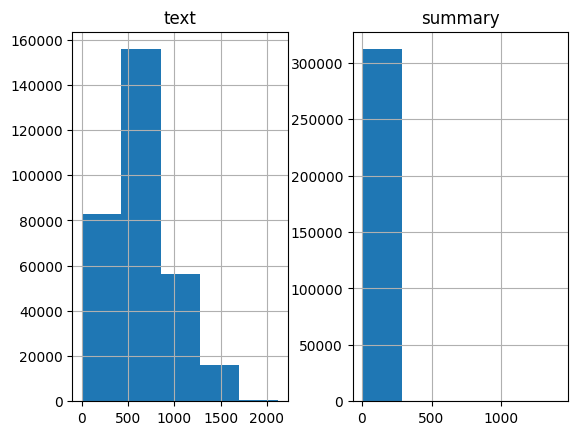

In [ ]:
import matplotlib.pyplot as plt

graph_df.hist(bins = 5)
plt.show()

In [ ]:
#Check how much % of summary have 0-15 words
cnt=0
for i in Data['cleaned_summary']:
    if(len(i.split())<=100):
        cnt=cnt+1
print(cnt/len(Data['cleaned_summary']))

0.9787223812469749


In [ ]:
#Check how much % of text have 0-70 words
cnt=0
for i in Data['cleaned_text']:
    if(len(i.split())<=1000):
        cnt=cnt+1
print(cnt/len(Data['cleaned_text']))

0.8553487343374865


In [ ]:
#Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
max_text_len=1000
max_summary_len=100

In [ ]:
#Select the Summaries and Text between max len defined above

cleaned_text =np.array(Data['cleaned_text'])
cleaned_summary=np.array(Data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})

In [ ]:
post_pre.head()

,text,summary
0,london england reuters harry potter star danie...,_START_ harry potter star daniel radcliffe get...
1,editor note in our behind the scenes series cn...,_START_ mentally ill inmates in miami are hous...
2,minneapolis minnesota cnn drivers who were on ...,_START_ new thought was going to die driver sa...
3,washington cnn doctors removed five small poly...,_START_ five small polyps found during procedu...
4,cnn the national football league has indefini...,_START_ new nfl chief atlanta falcons owner cr...


In [ ]:
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [ ]:
post_pre.head()

,text,summary
0,london england reuters harry potter star danie...,sostok _START_ harry potter star daniel radcli...
1,editor note in our behind the scenes series cn...,sostok _START_ mentally ill inmates in miami a...
2,minneapolis minnesota cnn drivers who were on ...,sostok _START_ new thought was going to die dr...
3,washington cnn doctors removed five small poly...,sostok _START_ five small polyps found during ...
4,cnn the national football league has indefini...,sostok _START_ new nfl chief atlanta falcons o...


In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.1,random_state=0,shuffle=True)

In [ ]:
# Tokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
thresh=5

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 65.2589576046037
Total Coverage of rare words: 0.392481395924499


In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 169341


In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
thresh=5

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 67.07962464869506
Total Coverage of rare words: 1.385996301010038


In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 49081


In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [ ]:
from keras import backend as K
import gensim
from numpy import *
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

print("Size of vocabulary from the w2v model = {}".format(x_voc))

K.clear_session()

latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Size of vocabulary from the w2v model = 169341


2023-11-21 17:21:36.969132: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-21 17:21:36.985418: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-21 17:21:36.987603: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1000)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1000, 200)            3386820   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 lstm (LSTM)                 [(None, 1000, 300),          601200    ['embedding[0][0]']           
                              (None, 300),                                                        
                              (None, 300)]                                                    

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# ModelCheckpoint callback
save_freq = int((len(x_tr) * 10) / 128)

# ModelCheckpoint callback
checkpoint = ModelCheckpoint('model_epoch_{epoch:02d}.h5',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=False,
                             save_weights_only=False,
                             mode='auto',
                             save_freq=save_freq)

In [ ]:
history = model.fit([x_tr, y_tr[:,:-1]],
                    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:],
                    epochs=50,
                    callbacks=[es, checkpoint],  # Include both callbacks
                    batch_size=128,
                    validation_data=([x_val, y_val[:,:-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]))

Epoch 1/50
1852/1852 [==============================] - 1251s 675ms/step - loss: 3.2459 - val_loss: 3.1958
Epoch 2/50
1852/1852 [==============================] - 1247s 673ms/step - loss: 3.1782 - val_loss: 3.1285
Epoch 3/50
1852/1852 [==============================] - 1245s 672ms/step - loss: 3.1181 - val_loss: 3.0739
Epoch 4/50
1852/1852 [==============================] - 1245s 672ms/step - loss: 3.0715 - val_loss: 3.0404
Epoch 5/50
1852/1852 [==============================] - 1242s 671ms/step - loss: 3.0309 - val_loss: 2.9965
Epoch 6/50
1852/1852 [==============================] - 1244s 671ms/step - loss: 2.9948 - val_loss: 2.9656
Epoch 7/50
1852/1852 [==============================] - 1241s 670ms/step - loss: 2.9628 - val_loss: 2.9334
Epoch 8/50
1852/1852 [==============================] - 1241s 670ms/step - loss: 2.9332 - val_loss: 2.9058
Epoch 9/50
1852/1852 [==============================] - 1239s 669ms/step - loss: 2.9048 - val_loss: 2.8822
Epoch 10/50
1847/1852 [==============

In [ ]:
model.save('my_model')

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


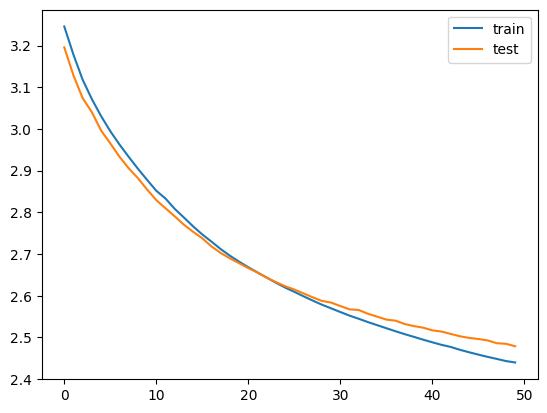

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(0,50):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: by daily mail reporter published 07 36 est 30 april 2012 updated 09 10 est 30 april 2012 student who was suffering from brain tumour was repeatedly turned away by doctors who insisted she was just homesick megan thompson who was just three weeks into her childhood studies course at leeds metropolitan university complained of terrible headaches and walking problems and made repeated trips to the doctor however it wasn until two months later that she was diagnosed with brain tumour the size of golf ball determined megan thompson with her mother sarah during treatment last year for brain cancer today the uk charity teenage charity trust revealed one in four young people with cancer had similar experience to megan and visited their doctor at least four times before they were taken seriously and referred to specialist the 20 year old student from sunderland who lives with her mother sarah and sister alice 16 said began to get the most horrendous headaches and couldn walk properly it